## Key Takeaways
* The "sell in May and go away" myth has been alive and well for the past 25 years.  Average returns in "winter" months have been more than 2x returns in "summer" months
* We also find strong weekly cycles, with Monday, Tuesday, and Wednesday producing more than 2x the rate of return (per day) as Thursday and Friday.   
* The strongest - and most consistent - cycle is monthly.  Best days are the end/beginning of the month and the 11th through 18th. 

## Introduction

Most investors have heard the adage "Sell in May and go away" which reflects the common wisdom that markets perform less well during the summer months than during the winter.  This anomaly is well described [here](https://www.investopedia.com/news/truth-about-sell-may-and-go-away/).  

Many widely held beliefs go away, precisely because they're widely held and get priced into the market.  I'd like to test the "sell in May" myth to see how well it has held up.  This is also a great case example to illustrate seasonality analysis - something which I believe gets too little attention because it seems "too simple" to work.  

In this post, I'll walk through a simple approach to replicating this anomaly using only end-of-day price data and a bit of python code.  If you'd like to replicate and experiment with the below code, _you can download the source notebook for this post by right-clicking on the below button and choosing "save link as"_ 

<a style="text-align: center;" href="https://github.com/convergenceIM/alpha-scientist/blob/master/content/Sell_in_May.ipynb"><img src="images/button_ipynb-notebook.png" title="download ipynb" /></a>

## Getting Started

We first need to load returns data.  You'll need to replace this code for your data source of choice, but make sure you use _adjusted_ returns, since unadjusted returns will introduce all sorts of errors related to dividend dates, changes in yield, splits and so forth.

Also, I'm going to use log returns here since they're additive across time.  In other words, the sum of daily log returns is equal to the monthly log return, which is not (quite) true of simple returns.  Since we are mostly using daily returns, you can more or less think of the log returns as simple returns.  

Our dataset goes back to the beginning of SPY in 1993

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
from IPython.core.display import Image

## The below imports interface to my (proprietary)
## price database.  Replace this code with your own
## source for downloading price data

import sys
sys.path.append('/anaconda/')
import config
sys.path.append(config.REPO_ROOT+'data/')
from prices.eod import read


## Load Data
symbols = ['SPY']
prices = read.get_symbols_close(symbols,adjusted=True)
returns = prices.pct_change()
log_ret = np.log(prices).diff()
spy = log_ret.SPY.dropna()
print(spy.head())


date
1993-02-01    0.007087
1993-02-02    0.002116
1993-02-03    0.010515
1993-02-04    0.004175
1993-02-05   -0.000695
Name: SPY, dtype: float64


### Sell in May?

We'll start analyzing the data by calculating average log returns by calendar month.  Note that, since we're using div/split adjusted prices, these are _total_ returns:

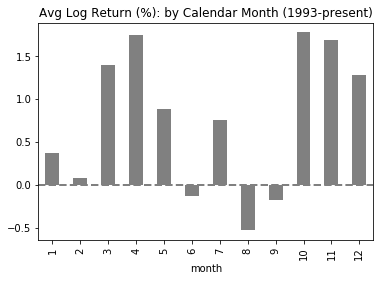

In [2]:
df = spy.to_frame(name='pct_chg')
by_month = df.resample('BM').sum()
by_month['month'] = by_month.index.month

title='Avg Log Return (%): by Calendar Month (1993-present)'
ax = (by_month.groupby('month').pct_chg.mean()*100).plot\
.bar(color='grey',title=title)
ax.axhline(y=0.00, color='grey', linestyle='--', lw=2)



Wow, maybe there's some truth to this myth!  It appears that there is a strong difference between the summer months (June to September) and the rest.  

From the above chart, it appears than we'd be well advised to sell on June 1st and buy back on September 30th.  However, to follow the commonly used interpretation of selling on May 1st and repurchasing on Oct 31st.  I'll group the data into those two periods and calculate the monthly average:

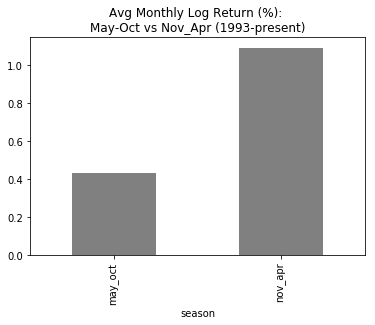

In [3]:
by_month['season'] = None
by_month.loc[by_month.month.between(5,10),'season'] = 'may_oct'
by_month.loc[~by_month.month.between(5,10),'season'] = 'nov_apr'

(by_month.groupby('season').pct_chg.mean()*100).plot.bar\
(title='Avg Monthly Log Return (%): \nMay-Oct vs Nov_Apr (1993-present)'\
 ,color='grey')


A significant difference.  The "winter" months are more than double the average return of the summer months.  But has this anomaly been taken out of the market by genius quants and vampire squid?  Let's look at this breakout by year:

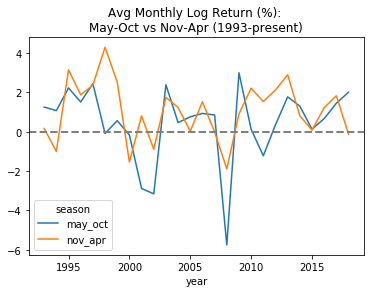

In [4]:
by_month['year'] = by_month.index.year

title='Avg Monthly Log Return (%): \nMay-Oct vs Nov-Apr (1993-present)'
ax = (by_month.groupby(['year','season']).pct_chg.mean().unstack()*100).plot(title=title)
ax.axhline(y=0.00, color='grey', linestyle='--', lw=2)

It's a bit noisy, so let's make a four year rolling average):

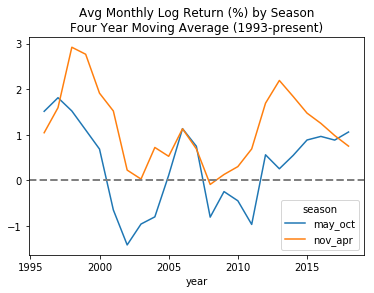

In [5]:
title='Avg Monthly Log Return (%) by Season\nFour Year Moving Average (1993-present)'
by_month['year'] = by_month.index.year
ax = (by_month.groupby(['year','season']).pct_chg.mean().unstack().rolling(4).mean()*100).plot(title=title)
ax.axhline(y=0.00, color='grey', linestyle='--', lw=2)

It appears that the effect hasn't gone away at all!  If anything, it's had a resurgence in the past 10 years.  

One theory I've seen floated is that this is predominantly driven by presidential elections - and the market uncertainty thereof.  To test that, I'll group data into election years and non-election years:

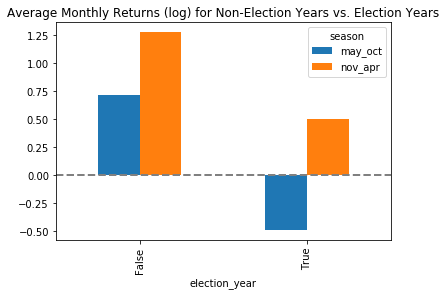

In [6]:
election_years = ['1996','2000','2004','2008','2012','2016']
by_month['election_year'] = False
by_month.loc[by_month.year.isin(election_years),'election_year'] = True

title = 'Average Monthly Returns (log) for Non-Election Years vs. Election Years'
ax = (by_month.groupby(['election_year','season']).pct_chg.mean()\
      .unstack()*100).plot.bar(title=title)
ax.axhline(y=0.00, color='grey', linestyle='--', lw=2)

Indeed, there does appear to be _more_ truth to the axiom in election years, but it remains significantly valid in off years as well.  Mark Hulbert [analyzed this theory](https://www.marketwatch.com/story/heres-the-real-story-behind-sell-in-may-and-go-away-2017-04-25) back to 1897 and sees similar results.  

### Day of Week
Now that we've validated our first pattern, I'd like to test for other calendar patterns.  Let's first look at days of week, looking at the average return by day of week:

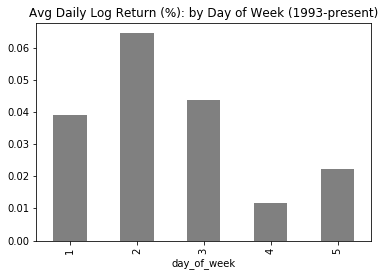

In [7]:
df = spy.to_frame(name='pct_chg')
by_day = df
by_day['day_of_week'] = by_day.index.weekday+ 1

(by_day.groupby('day_of_week').pct_chg.mean()*100).plot.bar\
(title='Avg Daily Log Return (%): by Day of Week (1993-present)',color='grey')


This seems promising.  Monday to Weds seems significantly better than Thurs and Friday.  Anyone care to hypothesize why?

I'll follow the same code pattern as with the "sell in May" analysis and group the days into these two halves, calculate in total as well as on a four-year-rolling basis.  

Text(0.5,1,'Avg Daily Log Return (%) by Part of Week\nFour Year Moving Average (1993-present)')

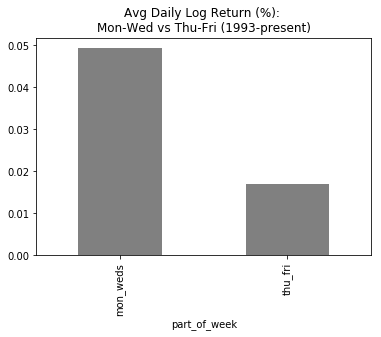

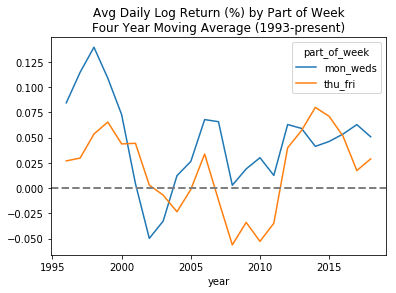

In [8]:
by_day['part_of_week'] = None
by_day.loc[by_day.day_of_week <=3,'part_of_week'] = 'mon_weds'
by_day.loc[by_day.day_of_week >3,'part_of_week'] = 'thu_fri'

(by_day.groupby('part_of_week').pct_chg.mean()*100).plot.bar\
(title='Avg Daily Log Return (%): \nMon-Wed vs Thu-Fri (1993-present)'\
 ,color='grey')

title='Avg Daily Log Return (%) by Part of Week\nFour Year Moving Average (1993-present)'
by_day['year'] = by_day.index.year
ax = (by_day.groupby(['year','part_of_week']).pct_chg.mean().unstack().rolling(4).mean()*100).plot()
ax.axhline(y=0.00, color='grey', linestyle='--', lw=2)
ax.set_title(title)


The average daily return (log) for Mon to Weds is considerably more than 2x the daily return of Thursdays and Fridays.   

It also appears to be a good bit less stable than the "sell-in-May" results.   I'd be hesitant to say that the anomaly is dead, however.  Just periodically dormant.  

### Day of Month
Now let's look in the data for any patters in the day of month:

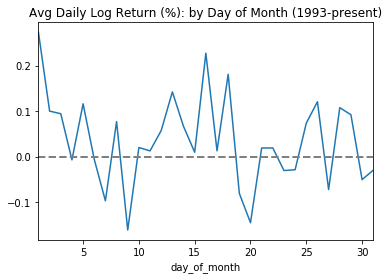

In [9]:
by_day['day_of_month'] = by_day.index.day 

title='Avg Daily Log Return (%): by Day of Month (1993-present)'

ax = (by_day.groupby('day_of_month').pct_chg.mean()*100).plot(xlim=(1,31),title=title)
ax.axhline(y=0.00, color='grey', linestyle='--', lw=2)

It seems pretty clear that there are some parts of the month which, on average, have much better/worse returns.  By my eye, it appears that the change of month (from about the 28th to the 5th) as well as the early/mid-part of month (say 11th thru 18th) are the "good" days and the rest are not.  

I'll follow the same approach and group the data into the "good days" (28-5, 11-18) and the "other days":  

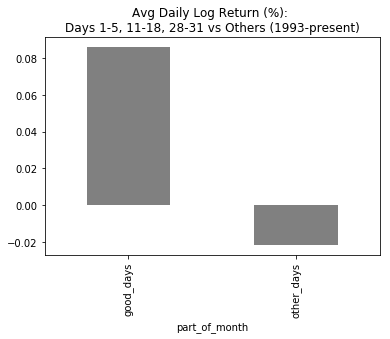

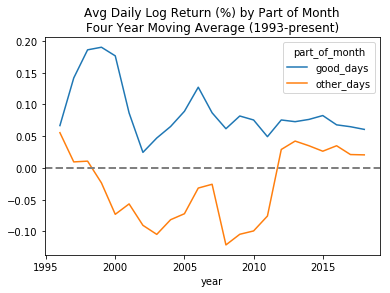

In [10]:
by_day['part_of_month'] = None
good_days = [1,2,3,4,5,11,12,13,14,15,16,17,18,28,29,30,31]
by_day.loc[by_day.day_of_month.isin(good_days),'part_of_month'] = 'good_days'
by_day.loc[~by_day.day_of_month.isin(good_days),'part_of_month'] = 'other_days'

(by_day.groupby('part_of_month').pct_chg.mean()*100).plot.bar\
(title='Avg Daily Log Return (%): \nDays 1-5, 11-18, 28-31 vs Others (1993-present)'\
 ,color='grey')

title='Avg Daily Log Return (%) by Part of Month\nFour Year Moving Average (1993-present)'
by_day['year'] = by_day.index.year
ax = (by_day.groupby(['year','part_of_month']).pct_chg.mean().unstack().rolling(4).mean()*100).plot(title=title)
ax.axhline(y=0.00, color='grey', linestyle='--', lw=2)

Systematic investing in the 90's and 00's must have been easy!  Even since the spread between the good days vs. the other days has narrowed, it is still quite significant.  The below table shows the past 5 years' returns.  It's not even close...

I'm quite interested in hypotheses for this anomaly in particular, since it's so persistent over time - and undeniably still in effect.  Possibilities: 
* Institutional/Retail fund flows?  
* Options/futures settlements?  
* Window dressing?
* Buybacks?  

In [11]:
print(by_day.groupby(['year','part_of_month']).pct_chg.mean().unstack().tail(5)*100)

part_of_month  good_days  other_days
year                                
2014            0.080266    0.014217
2015            0.022733   -0.016077
2016            0.058032    0.029643
2017            0.098606    0.056520
2018            0.063430    0.012229


## Conclusion

As irrational as it may seem, there are some major seasonality effects remaining in even the most liquid markets.  Quite honestly, this is __much__ more significant than I expected to find.  If any of my fellow skeptics want to replicate this on their own datasets, please message me with your results.  

If the future looks anything like the past (insert standard disclaimer about past performance...) then rules of thumb might be:
* Sell on Labor Day and buy on Halloween - especially do this on election years!  This assumes that you've got a productive use for the cash!  
* Do your buying at Friday's close, do your selling at Wednesday's close
* Maximize your exposure at the end/beginning of months and during the early-middle part of the month, lighten up.
* Remember that, in most of these anomalies, _total_ return would decrease by only participating in part of the market since any positive return is better than sitting in cash.  Risk-adjusted returns would be significantly improved by only participating in the most favorable periods.  It's for each investor to decide what's important to them.  

I had intended to extend this analysis to other asset classes, but will save that for a future post.  I'd like to expand this to small caps, rest-of-world developed/emerging, fixed income, growth, value, etc... 


### One last thing...

If you've found this post useful, please follow [@data2alpha](https://twitter.com/data2alpha) on twitter and forward to a friend or colleague who may also find this topic interesting.

Finally, take a minute to leave a comment below.  Share your thoughts on this post or to offer an idea for future posts.  Thanks for reading!